# Fun wuth Gamma Ray Bursts

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



In [59]:
names


array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [60]:
print(data[6])

# Duration of the time interval during which 90% of the GRB photon counts are observed
T90 = np.array(data[6], dtype = float)

ra = np.array(data[3], dtype = float)

decl = np.array(data[4], dtype = float)

# The time integrated total energy per unit surface.
fluence = np.array (data[9], dtype = float)

z =  np.array(data[11], dtype = float)   # we don't know selection effects of long gamma ray burst... 

T100 =  np.array(data[12], dtype = float)

#print(data[13])

['32.0010' '12.2880' '6.2720' ... '3.1360' '208.5760' '5.1840']


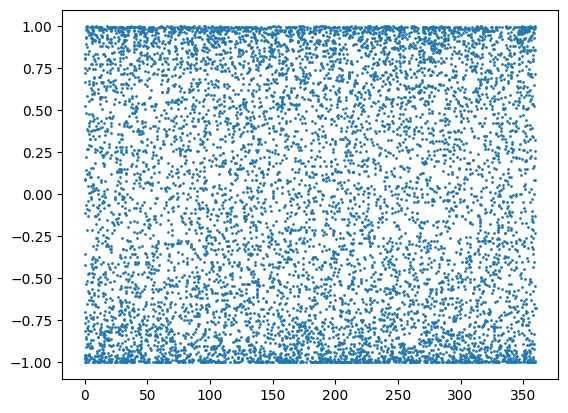

In [61]:
plt.scatter(ra, np.cos(decl), s= 1)
plt.show()

plt.scatter(ra, np.cos(decl), s= 1)
plt.show()

In [62]:
T90_mask = T90 > 0
fluence_mask = fluence > 0
mask = T90_mask & fluence_mask

T90_masked = np.array( T90[mask], dtype = float)
fluence_masked = np.array(fluence[mask], dtype = float)

In [63]:
print(fluence)

[1.2591e-05 1.4598e-05 2.3831e-06 ... 2.4858e-08 1.6510e-07 2.6055e-06]


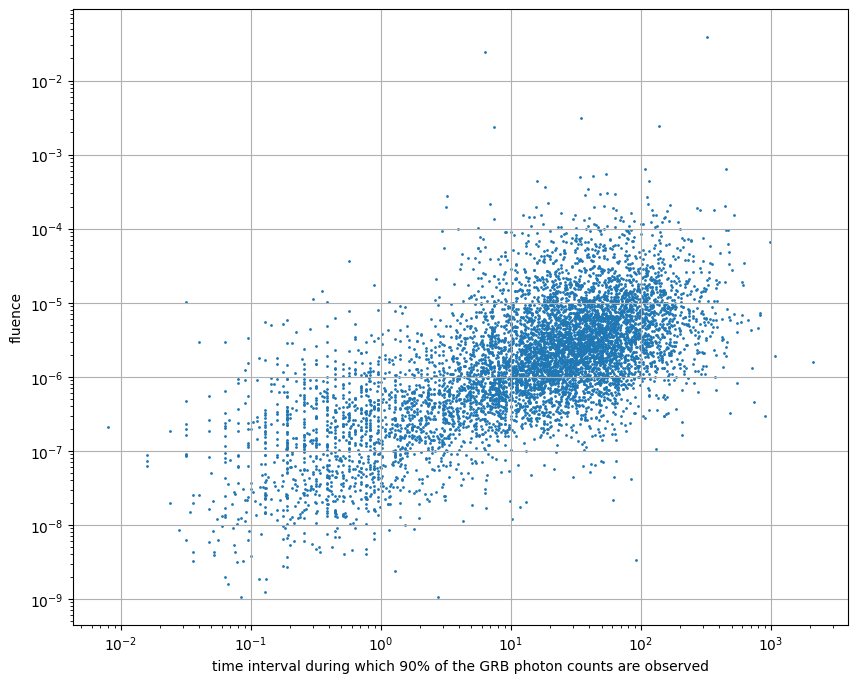

In [64]:
plt.figure(figsize = (10,8))
plt.scatter(T90[mask], fluence[mask], s= 1)
plt.xlabel("time interval during which 90% of the GRB photon counts are observed")
plt.ylabel("fluence")
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()

(7336, 2)
CLUSTER CENTERS: [[  3.50434976 -12.58452672]
 [  0.11568159 -15.50269279]]


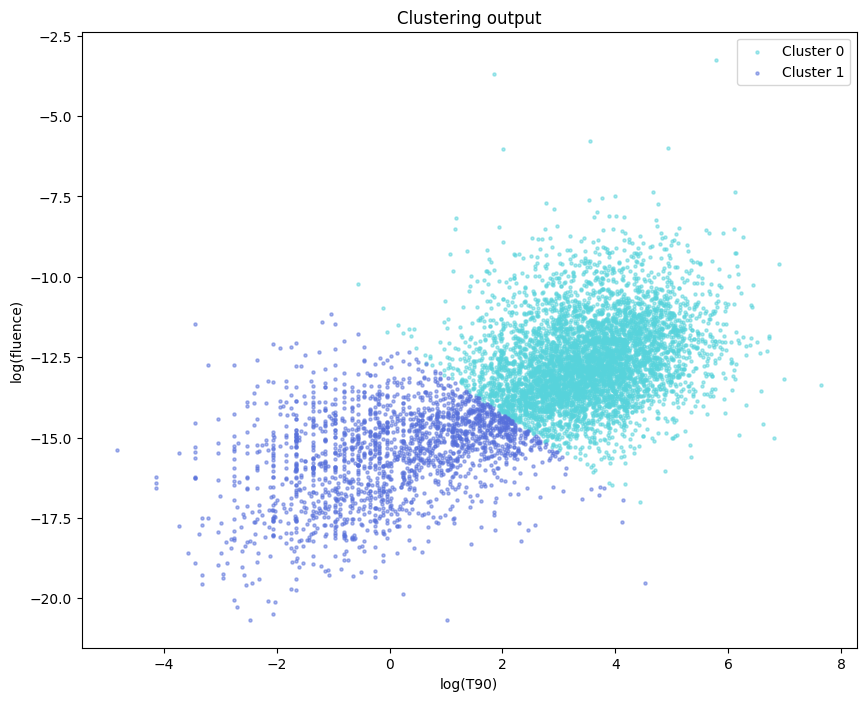

In [188]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

X = np.array([np.log(T90_masked), np.log(fluence_masked)]).T
print(X.shape)


clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

plt.figure(figsize = (10,8))

# plot the data color-coded by cluster id
colors = sns.color_palette("hls", 8)[4:]
for ii in range(2):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5, s= 5, label = 'Cluster %i'%ii)

# To get some information on these try:
# KMeans?
# help(clf)

#plt.xscale('log')
#plt.yscale('log')
plt.title('Clustering output');
plt.xlabel('log(T90)')
plt.ylabel('log(fluence)')
plt.legend()

print("CLUSTER CENTERS:", centers)

## plot the histogram of T90, use KDE

### clustering maybe too data driven, try and see gaussian mixture and get the means, is it near the cluster centers?

In [177]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift

scaler = preprocessing.StandardScaler()
bandwidth = 0.5
#bandwidth = estimate_bandwidth(X_reduced) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(X))

MeanShift(bandwidth=0.5, bin_seeding=True, cluster_all=False)

[-1  0  1  2  3  4  5  6  7  8  9 10]
0.5
number of estimated clusters : 11


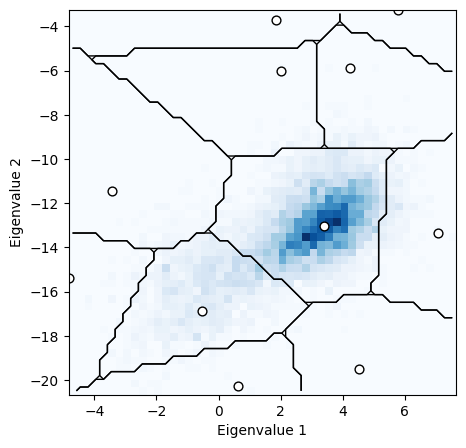

In [178]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()

# to account for errors one could run an mcmc (?)

# I want to look also at fluence vs redshift

In [179]:
z

array([-999., -999., -999., ..., -999., -999., -999.])

In [180]:
z_mask = z > 0
fluence_mask = fluence > 0
mask_2 = z_mask & fluence_mask

z_masked = np.array( z[mask_2], dtype = float)
fluence_masked_2 = np.array(fluence[mask_2], dtype = float)

print(z_masked.shape, fluence_masked.shape)

(586,) (7336,)


(586, 2)
0 (0.33999999999999997, 0.8287999999999999, 0.86)
1 (0.33999999999999997, 0.43879999999999986, 0.86)
CLUSTER CENTERS: [[  3.51753336 -12.56907844]
 [  0.16146095 -15.47402484]]


/tmp/ipykernel_36992/3210246103.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_2[labels_2==ii,0], X_2[labels_2==ii,1],


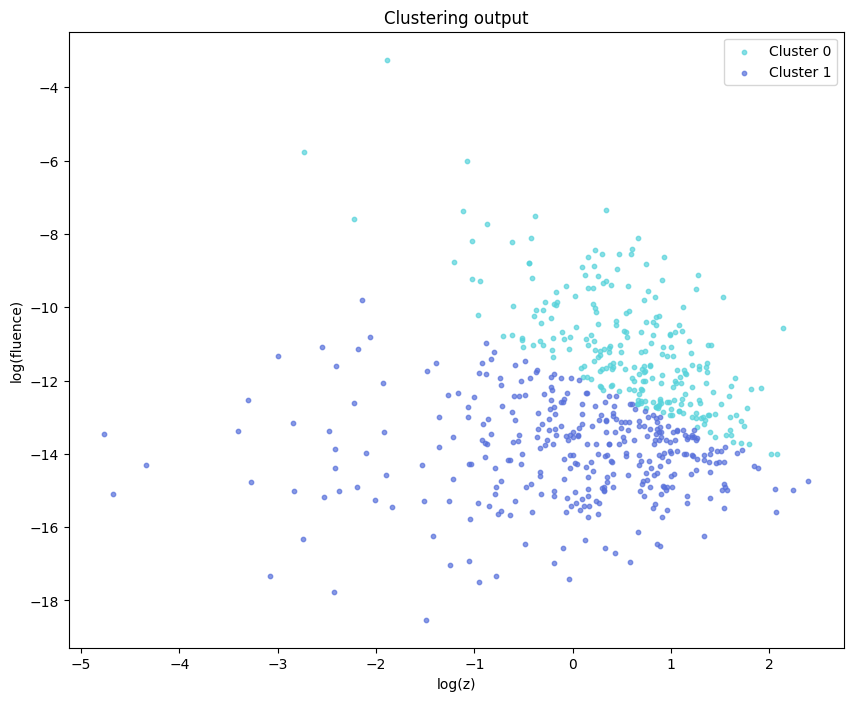

In [187]:

X_2 = np.array([np.log(z_masked), np.log(fluence_masked_2)]).T
print(X_2.shape)


clf_2 = KMeans(n_clusters=2) #Try 2 clusters to start with
clf_2.fit(X)
centers_2 = clf_2.cluster_centers_ #location of the clusters
labels_2 = clf_2.predict(X_2) #labels for each of the points
#print(labels)

plt.figure(figsize = (10,8))

# plot the data color-coded by cluster id
colors = sns.color_palette("hls", 8)[4:]
for ii in range(2):
    print(ii, str(colors[ii]))
    plt.scatter(X_2[labels_2==ii,0], X_2[labels_2==ii,1], 
                c=(colors[ii]),alpha=0.7, s =10, label = 'Cluster %d'%ii)

# To get some information on these try:
# KMeans?
# help(clf)

#plt.xscale('log')
#plt.yscale('log')
plt.title('Clustering output');
plt.xlabel("log(z)")
plt.ylabel("log(fluence)") 
plt.legend()

print("CLUSTER CENTERS:", centers_2)

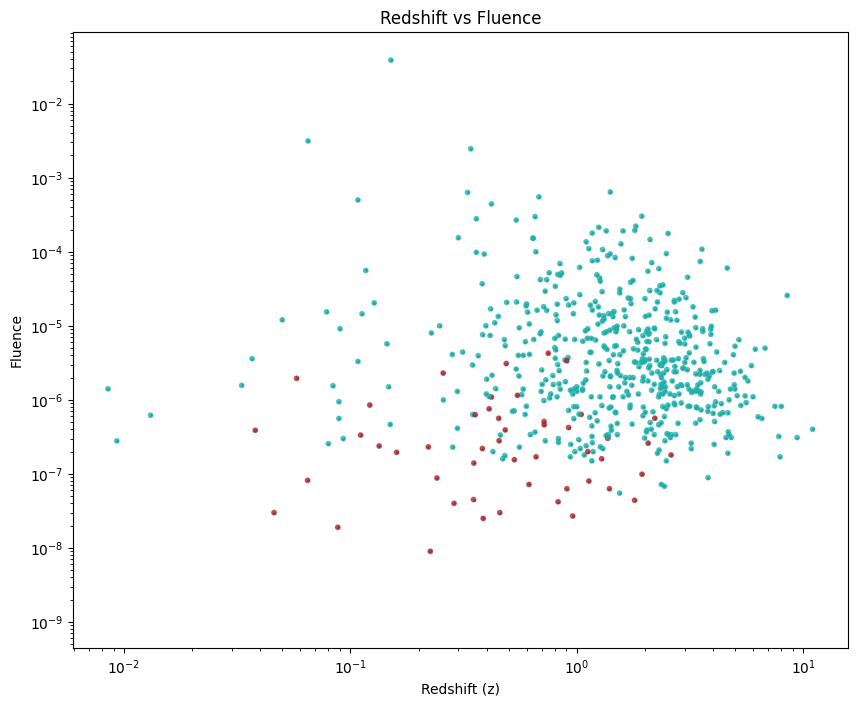

In [182]:
plt.figure(figsize=(10, 8))
plt.scatter(z[T90_mask], fluence[T90_mask], s=1)
plt.xlabel('Redshift (z)')
plt.ylabel('Fluence')
plt.title('Redshift vs Fluence')
plt.xscale('log')
plt.yscale('log')

# Assign different colors to long and short GRBs
colors = ['lightseagreen' if t > 2 else 'firebrick' for t in T90[T90_mask]]

# Plot the scatter plot with different colors
plt.scatter(z[T90_mask], fluence[T90_mask], s=10, c=colors, alpha=0.7)

# Add labels and title
plt.xlabel('Redshift (z)')
plt.ylabel('Fluence')
plt.title('Redshift vs Fluence')

# Set the scale to logarithmic
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

In [183]:
#mask on all three and plot both fluence vs T90 and fluence vs z
mask_3 = T90_mask & fluence_mask & z_mask

T90_masked_3 = np.array( T90[mask_3], dtype = float)
fluence_masked_3 = np.array(fluence[mask_3], dtype = float)
z_masked_3 = np.array( z[mask_3], dtype = float)

X_3 = np.array([np.log(T90_masked_3), np.log(fluence_masked_3)]).T
print(X_3.shape)

X_4 = np.array([np.log(z_masked_3), np.log(fluence_masked_3)]).T
print(X_4.shape)

clf_3 = KMeans(n_clusters=2)
clf_3.fit(X_3)
centers_3 = clf_3.cluster_centers_
labels_3 = clf_3.predict(X_3)



(573, 2)
(573, 2)


0 (0.33999999999999997, 0.43879999999999986, 0.86)
1 (0.6311999999999998, 0.33999999999999997, 0.86)
CLUSTER CENTERS: [[  1.45339424 -14.71746501]
 [  4.20782414 -11.85150744]]


/tmp/ipykernel_36992/902565518.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_3[labels_3==ii,0], X_3[labels_3==ii,1],


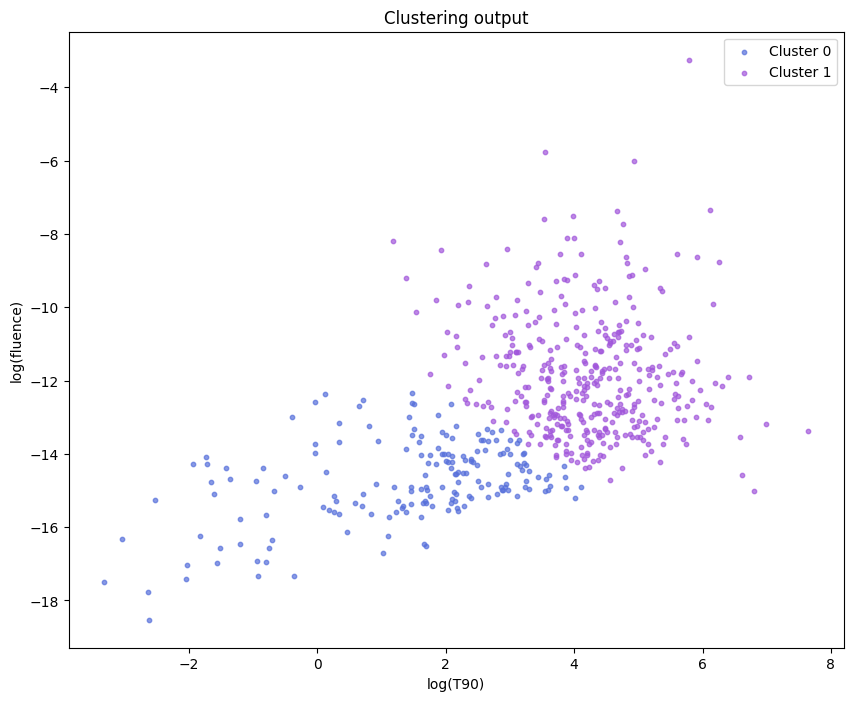

In [184]:
plt.figure(figsize = (10,8))

# plot the data color-coded by cluster id
colors = sns.color_palette("hls", 8)[5:]
for ii in range(2):
    print(ii, str(colors[ii]))
    plt.scatter(X_3[labels_3==ii,0], X_3[labels_3==ii,1], 
                c=(colors[ii]),alpha=0.7, s = 10, label = 'Cluster '+str(ii))

# To get some information on these try:
# KMeans?
# help(clf)

#plt.xscale('log')
#plt.yscale('log')
plt.title('Clustering output');
plt.xlabel("log(T90)")
plt.ylabel("log(fluence)") 
plt.legend()

print("CLUSTER CENTERS:", centers_3)

0 (0.33999999999999997, 0.43879999999999986, 0.86)
1 (0.6311999999999998, 0.33999999999999997, 0.86)
CLUSTER CENTERS: [[  0.18377448 -10.7708942 ]
 [  0.29500937 -14.00967267]]


/tmp/ipykernel_36992/625471231.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_4[labels_3==ii,0], X_4[labels_3==ii,1],


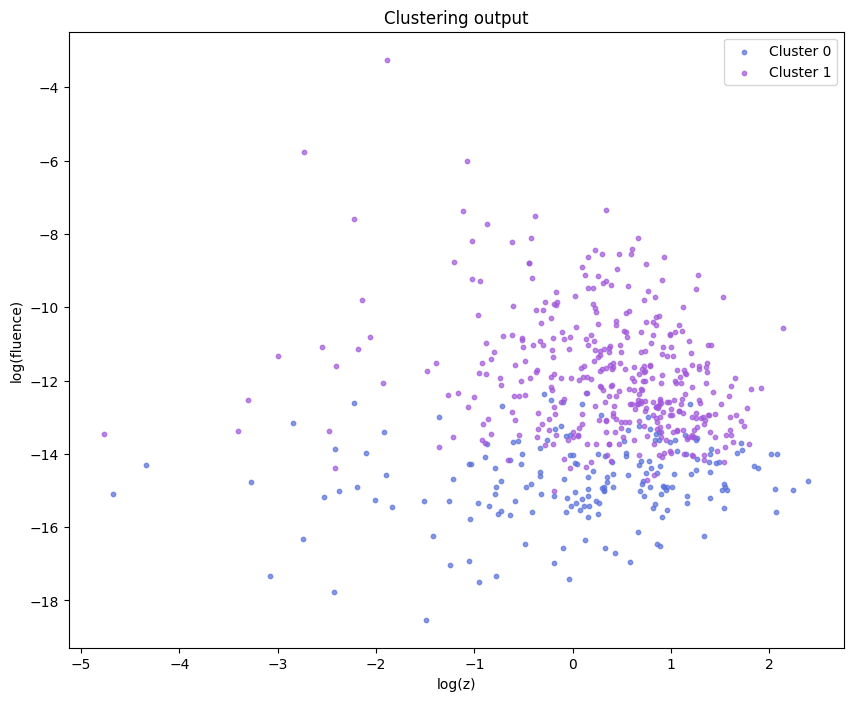

In [185]:
plt.figure(figsize = (10,8))

# plot the data color-coded by cluster id
colors = sns.color_palette("hls", 8)[5:]
for ii in range(2):
    print(ii, str(colors[ii]))
    plt.scatter(X_4[labels_3==ii,0], X_4[labels_3==ii,1], 
                c=(colors[ii]),alpha=0.7, s = 10, label = 'Cluster ' + str(ii))

# To get some information on these try:
# KMeans?
# help(clf)

#plt.xscale('log')
#plt.yscale('log')
plt.title('Clustering output');
plt.xlabel("log(z)")
plt.ylabel("log(fluence)") 
plt.legend()

print("CLUSTER CENTERS:", centers_4)

# what could I add to undestrand the physics? can I do PCA??? I donn't know if we have any other interesting variables...

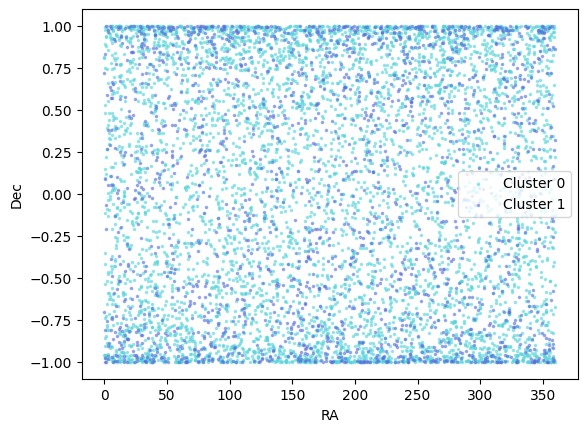

In [186]:
#I could look at their positions in the sky and see if they are clustered in any way.

ra_masked = np.array( ra[mask], dtype = float)
decl_masked = np.array(decl[mask], dtype = float)

X_5 = np.array([ra_masked, decl_masked]).T

colors = sns.color_palette("hls", 8)[4:]
for ii in range(2):
    plt.scatter(X_5[labels==ii,0], np.cos(X_5[labels==ii,1]), 
                color=colors[ii], s= 2.5, alpha=0.5, label = 'Cluster ' + str(ii))

plt.xlabel("RA")
plt.ylabel("Dec")
plt.legend()


